Beats per Minute Prediction Competition on Kaggle


In [8]:
#Import libraries

import pandas as pd
import numpy as np 
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [9]:
#Import the data

sample_submission = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [19]:
print(train.shape)
print(train.columns)
print(train.head())
print(train.info())

(524164, 11)
Index(['id', 'RhythmScore', 'AudioLoudness', 'VocalContent', 'AcousticQuality',
       'InstrumentalScore', 'LivePerformanceLikelihood', 'MoodScore',
       'TrackDurationMs', 'Energy', 'BeatsPerMinute'],
      dtype='object')
   id  RhythmScore  AudioLoudness  VocalContent  AcousticQuality  \
0   0     0.603610      -7.636942      0.023500         0.000005   
1   1     0.639451     -16.267598      0.071520         0.444929   
2   2     0.514538     -15.953575      0.110715         0.173699   
3   3     0.734463      -1.357000      0.052965         0.001651   
4   4     0.532968     -13.056437      0.023500         0.068687   

   InstrumentalScore  LivePerformanceLikelihood  MoodScore  TrackDurationMs  \
0           0.000001                   0.051385   0.409866      290715.6450   
1           0.349414                   0.170522   0.651010      164519.5174   
2           0.453814                   0.029576   0.423865      174495.5667   
3           0.159717               

Using my knowledge of music, I know that the key to BPM is sitting somewhere in the Rhythm score as that is the group charged with establishing timing for the song.

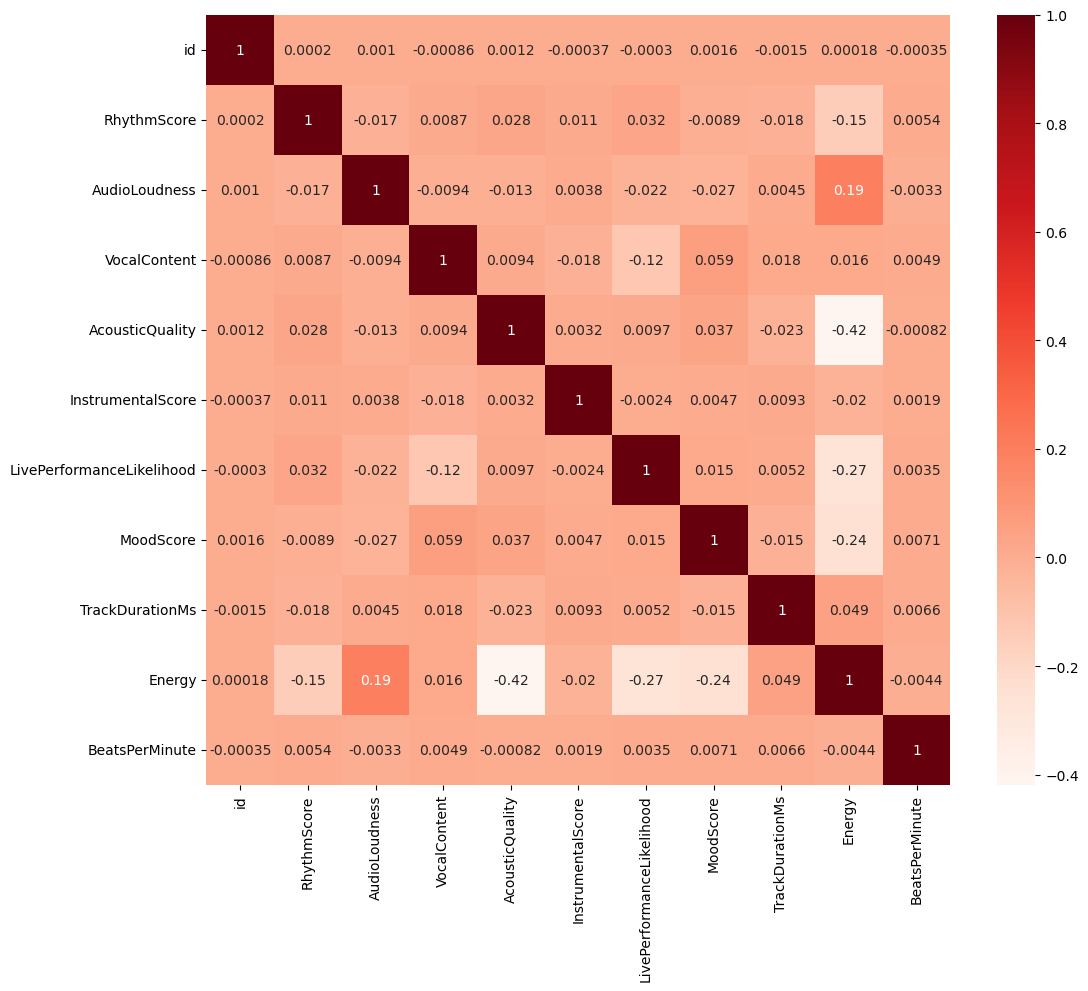

In [11]:
#Chreate a heatmap to see correlations against BeatsPerMinute

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
cor = train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

We can see that rhythm score has the most noticiable correlation with the overall BPM for the songs along. The rest of the features appear to to weak correlation but none is strong enough or weak enough to remove from the model. 

In [12]:
# Prepare the data for modeling
# Separate features and target
X = train.drop(['id', 'BeatsPerMinute'], axis=1)
y = train['BeatsPerMinute']
X_test = test.drop(['id'], axis=1)

# Split data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Feature columns: {list(X.columns)}")
print(f"Target stats - Mean: {y.mean():.2f}, Std: {y.std():.2f}, Min: {y.min():.2f}, Max: {y.max():.2f}")

Training set shape: (419331, 9)
Validation set shape: (104833, 9)
Test set shape: (174722, 9)
Feature columns: ['RhythmScore', 'AudioLoudness', 'VocalContent', 'AcousticQuality', 'InstrumentalScore', 'LivePerformanceLikelihood', 'MoodScore', 'TrackDurationMs', 'Energy']
Target stats - Mean: 119.03, Std: 26.47, Min: 46.72, Max: 206.04


## XGBoost Model with Optuna Hyperparameter Tuning

In [13]:
# XGBoost with Optuna hyperparameter tuning
def objective_xgb(trial):
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Create and train model
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    
    # Predict and calculate score
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    return rmse

# Run optimization
print("Starting XGBoost hyperparameter optimization...")
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=50)

print(f"Best RMSE: {study_xgb.best_value:.4f}")
print(f"Best parameters: {study_xgb.best_params}")

# Train final XGBoost model with best parameters
best_xgb = xgb.XGBRegressor(**study_xgb.best_params, random_state=42, n_jobs=-1)
best_xgb.fit(X_train, y_train)

# Evaluate on validation set
xgb_pred_val = best_xgb.predict(X_val)
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred_val))
xgb_mae = mean_absolute_error(y_val, xgb_pred_val)
xgb_r2 = r2_score(y_val, xgb_pred_val)

print(f"\nXGBoost Validation Results:")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"MAE: {xgb_mae:.4f}")
print(f"R²: {xgb_r2:.4f}")

[I 2025-09-27 08:58:02,267] A new study created in memory with name: no-name-2719f10c-5d05-4e8a-8260-607353baee84


Starting XGBoost hyperparameter optimization...


[I 2025-09-27 08:58:05,111] Trial 0 finished with value: 26.47778595486917 and parameters: {'n_estimators': 627, 'max_depth': 7, 'learning_rate': 0.028349220027688395, 'subsample': 0.6638648687361631, 'colsample_bytree': 0.9748774034041154, 'reg_alpha': 8.828578157033446, 'reg_lambda': 4.383179180093498}. Best is trial 0 with value: 26.47778595486917.
[I 2025-09-27 08:58:07,656] Trial 1 finished with value: 27.020468373072543 and parameters: {'n_estimators': 732, 'max_depth': 6, 'learning_rate': 0.26738528003866013, 'subsample': 0.8196281652678811, 'colsample_bytree': 0.8835588702016326, 'reg_alpha': 3.2527858248101396, 'reg_lambda': 1.2729618446575464}. Best is trial 0 with value: 26.47778595486917.
[I 2025-09-27 08:58:12,065] Trial 2 finished with value: 27.98683221886965 and parameters: {'n_estimators': 448, 'max_depth': 10, 'learning_rate': 0.21678044251437767, 'subsample': 0.8447343802503424, 'colsample_bytree': 0.706213045147387, 'reg_alpha': 0.8531462251588051, 'reg_lambda': 0.4

Best RMSE: 26.4393
Best parameters: {'n_estimators': 272, 'max_depth': 5, 'learning_rate': 0.010104502860842923, 'subsample': 0.7564086110356711, 'colsample_bytree': 0.6674714103210228, 'reg_alpha': 7.917072831810263, 'reg_lambda': 7.882451780426688}

XGBoost Validation Results:
RMSE: 26.4393
MAE: 21.1815
R²: 0.0004


## LightGBM Model with Optuna Hyperparameter Tuning

In [14]:
# LightGBM with Optuna hyperparameter tuning
def objective_lgb(trial):
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    
    # Create and train model
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    
    # Predict and calculate score
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    return rmse

# Run optimization
print("Starting LightGBM hyperparameter optimization...")
study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=50)

print(f"Best RMSE: {study_lgb.best_value:.4f}")
print(f"Best parameters: {study_lgb.best_params}")

# Train final LightGBM model with best parameters
best_lgb = lgb.LGBMRegressor(**study_lgb.best_params, random_state=42, n_jobs=-1, verbose=-1)
best_lgb.fit(X_train, y_train)

# Evaluate on validation set
lgb_pred_val = best_lgb.predict(X_val)
lgb_rmse = np.sqrt(mean_squared_error(y_val, lgb_pred_val))
lgb_mae = mean_absolute_error(y_val, lgb_pred_val)
lgb_r2 = r2_score(y_val, lgb_pred_val)

print(f"\nLightGBM Validation Results:")
print(f"RMSE: {lgb_rmse:.4f}")
print(f"MAE: {lgb_mae:.4f}")
print(f"R²: {lgb_r2:.4f}")

[I 2025-09-27 08:59:24,344] A new study created in memory with name: no-name-65eaef29-4675-484e-9069-3bd871e83eb5


Starting LightGBM hyperparameter optimization...


[I 2025-09-27 08:59:28,027] Trial 0 finished with value: 26.847033506906627 and parameters: {'n_estimators': 943, 'max_depth': 6, 'learning_rate': 0.1969288537667001, 'subsample': 0.9623202196800982, 'colsample_bytree': 0.9533465045474007, 'reg_alpha': 4.438114156436024, 'reg_lambda': 2.001790556096333, 'num_leaves': 85}. Best is trial 0 with value: 26.847033506906627.
[I 2025-09-27 08:59:29,024] Trial 1 finished with value: 26.495892835888956 and parameters: {'n_estimators': 346, 'max_depth': 9, 'learning_rate': 0.13507658209354428, 'subsample': 0.6205096802550075, 'colsample_bytree': 0.681789671365453, 'reg_alpha': 8.95600106950253, 'reg_lambda': 4.402123068730598, 'num_leaves': 51}. Best is trial 1 with value: 26.495892835888956.
[I 2025-09-27 08:59:31,489] Trial 2 finished with value: 26.508758439476313 and parameters: {'n_estimators': 993, 'max_depth': 4, 'learning_rate': 0.1296402869869174, 'subsample': 0.8708479778939942, 'colsample_bytree': 0.7569004575029501, 'reg_alpha': 9.69

Best RMSE: 26.4373
Best parameters: {'n_estimators': 128, 'max_depth': 7, 'learning_rate': 0.01930167489117179, 'subsample': 0.6020108587315974, 'colsample_bytree': 0.6266863417135373, 'reg_alpha': 3.6278974212117854, 'reg_lambda': 9.828701769754765, 'num_leaves': 22}

LightGBM Validation Results:
RMSE: 26.4373
MAE: 21.1799
R²: 0.0006


## CatBoost Model with Optuna Hyperparameter Tuning

In [15]:
# CatBoost with Optuna hyperparameter tuning
def objective_cat(trial):
    # Suggest hyperparameters
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'random_seed': 42,
        'verbose': False
    }
    
    # Create and train model
    model = cb.CatBoostRegressor(**params)
    model.fit(X_train, y_train)
    
    # Predict and calculate score
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    return rmse

# Run optimization
print("Starting CatBoost hyperparameter optimization...")
study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat, n_trials=50)

print(f"Best RMSE: {study_cat.best_value:.4f}")
print(f"Best parameters: {study_cat.best_params}")

# Train final CatBoost model with best parameters
best_cat = cb.CatBoostRegressor(**study_cat.best_params, random_seed=42, verbose=False)
best_cat.fit(X_train, y_train)

# Evaluate on validation set
cat_pred_val = best_cat.predict(X_val)
cat_rmse = np.sqrt(mean_squared_error(y_val, cat_pred_val))
cat_mae = mean_absolute_error(y_val, cat_pred_val)
cat_r2 = r2_score(y_val, cat_pred_val)

print(f"\nCatBoost Validation Results:")
print(f"RMSE: {cat_rmse:.4f}")
print(f"MAE: {cat_mae:.4f}")
print(f"R²: {cat_r2:.4f}")

[I 2025-09-27 09:01:07,428] A new study created in memory with name: no-name-ad986922-f6e0-499e-86a9-fff1122447d0


Starting CatBoost hyperparameter optimization...


[I 2025-09-27 09:01:13,414] Trial 0 finished with value: 26.536579917023964 and parameters: {'iterations': 422, 'depth': 9, 'learning_rate': 0.11726076620187921, 'l2_leaf_reg': 1.3664426327924926, 'border_count': 43, 'bagging_temperature': 0.4477422622229038}. Best is trial 0 with value: 26.536579917023964.
[I 2025-09-27 09:01:15,301] Trial 1 finished with value: 26.442217238844293 and parameters: {'iterations': 224, 'depth': 3, 'learning_rate': 0.18116051965595867, 'l2_leaf_reg': 4.40113006554833, 'border_count': 192, 'bagging_temperature': 0.7654796771535747}. Best is trial 1 with value: 26.442217238844293.
[I 2025-09-27 09:01:25,023] Trial 2 finished with value: 26.44817040226053 and parameters: {'iterations': 891, 'depth': 6, 'learning_rate': 0.032580133199063104, 'l2_leaf_reg': 4.888670997927034, 'border_count': 135, 'bagging_temperature': 0.2589291100770973}. Best is trial 1 with value: 26.442217238844293.
[I 2025-09-27 09:01:45,284] Trial 3 finished with value: 27.24125793256568

Best RMSE: 26.4386
Best parameters: {'iterations': 715, 'depth': 4, 'learning_rate': 0.010169709385097432, 'l2_leaf_reg': 6.73168728004266, 'border_count': 95, 'bagging_temperature': 0.0038178363607959676}

CatBoost Validation Results:
RMSE: 26.4386
MAE: 21.1804
R²: 0.0005


## Model Comparison and Ensemble

In [20]:
# Compare all models
import pandas as pd

results_df = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'CatBoost'],
    'RMSE': [xgb_rmse, lgb_rmse, cat_rmse],
    'MAE': [xgb_mae, lgb_mae, cat_mae],
    'R²': [xgb_r2, lgb_r2, cat_r2]
})

print("Model Comparison:")
print(results_df.round(4))

# Find best model
best_model_idx = results_df['RMSE'].idxmin()
best_model_name = results_df.loc[best_model_idx, 'Model']
print(f"\nBest single model: {best_model_name}")

# Create ensemble predictions (simple average)
ensemble_pred_val = (xgb_pred_val + lgb_pred_val + cat_pred_val) / 3
ensemble_rmse = np.sqrt(mean_squared_error(y_val, ensemble_pred_val))
ensemble_mae = mean_absolute_error(y_val, ensemble_pred_val)
ensemble_r2 = r2_score(y_val, ensemble_pred_val)

print(f"\nEnsemble Model Results:")
print(f"RMSE: {ensemble_rmse:.4f}")
print(f"MAE: {ensemble_mae:.4f}")
print(f"R²: {ensemble_r2:.4f}")

# Add ensemble to comparison
results_df = pd.concat([results_df, pd.DataFrame({
    'Model': ['Ensemble'],
    'RMSE': [ensemble_rmse],
    'MAE': [ensemble_mae],
    'R²': [ensemble_r2]
})], ignore_index=True)

print("\nFinal Model Comparison (including ensemble):")
print(results_df.round(4))

Model Comparison:
      Model     RMSE      MAE      R²
0   XGBoost  26.4393  21.1815  0.0004
1  LightGBM  26.4373  21.1799  0.0006
2  CatBoost  26.4386  21.1804  0.0005

Best single model: LightGBM

Ensemble Model Results:
RMSE: 26.4380
MAE: 21.1803
R²: 0.0005

Final Model Comparison (including ensemble):
      Model     RMSE      MAE      R²
0   XGBoost  26.4393  21.1815  0.0004
1  LightGBM  26.4373  21.1799  0.0006
2  CatBoost  26.4386  21.1804  0.0005
3  Ensemble  26.4380  21.1803  0.0005


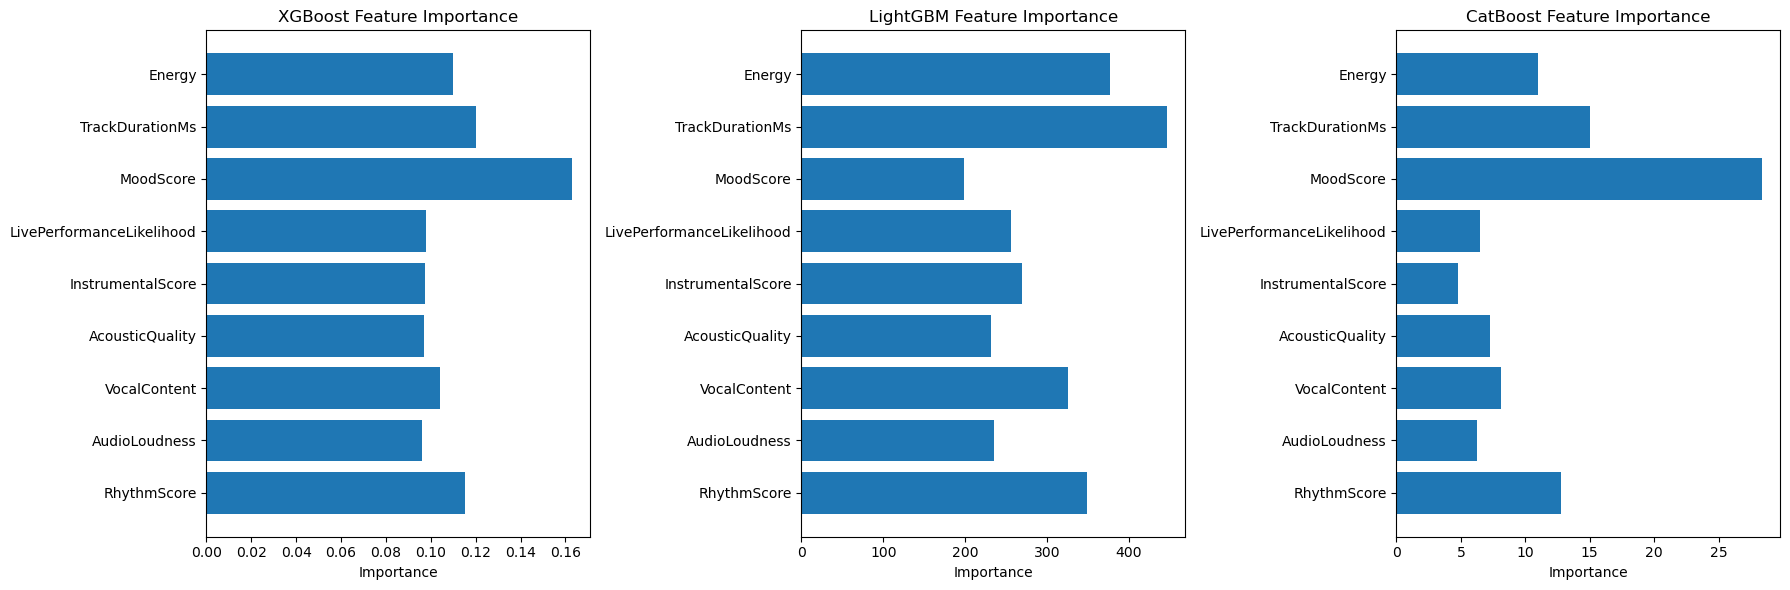

Feature Importance Summary:
                     Feature  XGBoost  LightGBM  CatBoost   Average
7            TrackDurationMs   0.1200       446   15.0174  153.7125
8                     Energy   0.1097       377   10.9657  129.3585
0                RhythmScore   0.1154       349   12.8106  120.6420
2               VocalContent   0.1039       325    8.0765  111.0602
4          InstrumentalScore   0.0973       269    4.8050   91.3008
5  LivePerformanceLikelihood   0.0977       256    6.5026   87.5335
1              AudioLoudness   0.0961       235    6.2371   80.4444
3            AcousticQuality   0.0971       232    7.2305   79.7759
6                  MoodScore   0.1628       199   28.3544   75.8391


In [17]:
# Feature importance visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# XGBoost feature importance
xgb_importance = best_xgb.feature_importances_
axes[0].barh(X.columns, xgb_importance)
axes[0].set_title('XGBoost Feature Importance')
axes[0].set_xlabel('Importance')

# LightGBM feature importance
lgb_importance = best_lgb.feature_importances_
axes[1].barh(X.columns, lgb_importance)
axes[1].set_title('LightGBM Feature Importance')
axes[1].set_xlabel('Importance')

# CatBoost feature importance
cat_importance = best_cat.feature_importances_
axes[2].barh(X.columns, cat_importance)
axes[2].set_title('CatBoost Feature Importance')
axes[2].set_xlabel('Importance')

plt.tight_layout()
plt.show()

# Average feature importance across all models
avg_importance = (xgb_importance + lgb_importance + cat_importance) / 3
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'XGBoost': xgb_importance,
    'LightGBM': lgb_importance,
    'CatBoost': cat_importance,
    'Average': avg_importance
}).sort_values('Average', ascending=False)

print("Feature Importance Summary:")
print(feature_importance_df.round(4))

## Generate Test Predictions

In [18]:
# Generate predictions on test set
xgb_test_pred = best_xgb.predict(X_test)
lgb_test_pred = best_lgb.predict(X_test)
cat_test_pred = best_cat.predict(X_test)
ensemble_test_pred = (xgb_test_pred + lgb_test_pred + cat_test_pred) / 3

# Create submission files for each model
submission_xgb = sample_submission.copy()
submission_xgb['BeatsPerMinute'] = xgb_test_pred

submission_lgb = sample_submission.copy()
submission_lgb['BeatsPerMinute'] = lgb_test_pred

submission_cat = sample_submission.copy()
submission_cat['BeatsPerMinute'] = cat_test_pred

submission_ensemble = sample_submission.copy()
submission_ensemble['BeatsPerMinute'] = ensemble_test_pred

# Save submission files
submission_xgb.to_csv('submission_xgboost.csv', index=False)
submission_lgb.to_csv('submission_lightgbm.csv', index=False)
submission_cat.to_csv('submission_catboost.csv', index=False)
submission_ensemble.to_csv('submission_ensemble.csv', index=False)

print("Submission files created:")
print("- submission_xgboost.csv")
print("- submission_lightgbm.csv")
print("- submission_catboost.csv")
print("- submission_ensemble.csv")

print(f"\nTest prediction statistics:")
print(f"XGBoost - Mean: {xgb_test_pred.mean():.2f}, Std: {xgb_test_pred.std():.2f}")
print(f"LightGBM - Mean: {lgb_test_pred.mean():.2f}, Std: {lgb_test_pred.std():.2f}")
print(f"CatBoost - Mean: {cat_test_pred.mean():.2f}, Std: {cat_test_pred.std():.2f}")
print(f"Ensemble - Mean: {ensemble_test_pred.mean():.2f}, Std: {ensemble_test_pred.std():.2f}")

# Display first few predictions
print(f"\nFirst 10 predictions comparison:")
comparison_df = pd.DataFrame({
    'ID': test['id'][:10],
    'XGBoost': xgb_test_pred[:10],
    'LightGBM': lgb_test_pred[:10],
    'CatBoost': cat_test_pred[:10],
    'Ensemble': ensemble_test_pred[:10]
})
print(comparison_df.round(2))

Submission files created:
- submission_xgboost.csv
- submission_lightgbm.csv
- submission_catboost.csv
- submission_ensemble.csv

Test prediction statistics:
XGBoost - Mean: 119.06, Std: 0.59
LightGBM - Mean: 119.05, Std: 0.57
CatBoost - Mean: 119.06, Std: 0.57
Ensemble - Mean: 119.06, Std: 0.56

First 10 predictions comparison:
       ID     XGBoost  LightGBM  CatBoost  Ensemble
0  524164  118.970001    118.82    119.08    118.96
1  524165  118.860001    119.15    118.93    118.98
2  524166  119.519997    119.51    119.63    119.55
3  524167  119.320000    119.30    119.38    119.33
4  524168  119.559998    119.32    119.39    119.42
5  524169  119.019997    119.14    119.09    119.08
6  524170  118.389999    118.77    118.64    118.60
7  524171  118.540001    118.71    118.74    118.66
8  524172  119.080002    118.90    118.94    118.97
9  524173  118.690002    118.81    118.67    118.72


# Advanced Model Improvement Techniques

## Installation of Additional Packages for GPU Acceleration and Advanced Models

In [21]:
# Install additional packages for advanced techniques
import subprocess
import sys

packages_to_install = [
    'cupy-cuda12x',  # GPU acceleration for CuPy
    'cudf-cu12',     # GPU DataFrame operations
    'cuml-cu12',     # GPU ML algorithms
    'ngboost',       # Natural Gradient Boosting
    'tabnet-pytorch', # TabNet neural network
    'torch',         # PyTorch for neural networks
    'optuna-integration[lightgbm,xgboost,catboost]',  # Enhanced Optuna integration
    'bayesian-optimization',  # Bayesian optimization
    'hyperopt',      # Hyperparameter optimization
    'sklearn-gpu'    # GPU sklearn
]

print("Installing advanced packages...")
for package in packages_to_install:
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✓ {package} installed successfully")
    except subprocess.CalledProcessError:
        print(f"✗ Failed to install {package}, skipping...")
        
print("Package installation complete!")

Installing advanced packages...
✓ cupy-cuda12x installed successfully
✗ Failed to install cudf-cu12, skipping...
✗ Failed to install cuml-cu12, skipping...
✓ ngboost installed successfully
✗ Failed to install tabnet-pytorch, skipping...
✓ torch installed successfully
✓ optuna-integration[lightgbm,xgboost,catboost] installed successfully
✓ bayesian-optimization installed successfully
✓ hyperopt installed successfully
✗ Failed to install sklearn-gpu, skipping...
Package installation complete!


In [23]:
# Enhanced imports for advanced modeling (with error handling)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.neural_network import MLPRegressor
import optuna.integration.lightgbm as lgb_optuna
import optuna.integration.xgboost as xgb_optuna
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# Try to import bayesian optimization, skip if not available
try:
    from bayesian_optimization import BayesianOptimization
    BAYESIAN_OPT_AVAILABLE = True
except ImportError:
    print("Bayesian optimization not available, using Optuna only")
    BAYESIAN_OPT_AVAILABLE = False

import gc

# Set device for PyTorch (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Enable GPU acceleration for XGBoost and LightGBM
gpu_params = {
    'tree_method': 'gpu_hist',
    'gpu_id': 0
} if torch.cuda.is_available() else {}

print("Advanced libraries imported successfully!")

Bayesian optimization not available, using Optuna only
Using device: cpu
Advanced libraries imported successfully!


## Advanced Feature Engineering

In [24]:
# Advanced Feature Engineering
def create_advanced_features(df):
    """Create advanced features for better model performance"""
    df_enhanced = df.copy()
    
    # Polynomial features for key relationships
    df_enhanced['RhythmScore_squared'] = df_enhanced['RhythmScore'] ** 2
    df_enhanced['RhythmScore_cubed'] = df_enhanced['RhythmScore'] ** 3
    df_enhanced['Energy_squared'] = df_enhanced['Energy'] ** 2
    df_enhanced['AudioLoudness_squared'] = df_enhanced['AudioLoudness'] ** 2
    
    # Interaction features (most promising based on domain knowledge)
    df_enhanced['Rhythm_Energy_interaction'] = df_enhanced['RhythmScore'] * df_enhanced['Energy']
    df_enhanced['Rhythm_Loudness_interaction'] = df_enhanced['RhythmScore'] * df_enhanced['AudioLoudness']
    df_enhanced['Energy_Loudness_interaction'] = df_enhanced['Energy'] * df_enhanced['AudioLoudness']
    df_enhanced['Rhythm_Duration_interaction'] = df_enhanced['RhythmScore'] * df_enhanced['TrackDurationMs']
    df_enhanced['Energy_Duration_interaction'] = df_enhanced['Energy'] * df_enhanced['TrackDurationMs']
    
    # Ratios and derived features
    df_enhanced['Vocal_Instrumental_ratio'] = df_enhanced['VocalContent'] / (df_enhanced['InstrumentalScore'] + 1e-8)
    df_enhanced['Acoustic_Energy_ratio'] = df_enhanced['AcousticQuality'] / (df_enhanced['Energy'] + 1e-8)
    df_enhanced['Duration_minutes'] = df_enhanced['TrackDurationMs'] / 60000
    df_enhanced['Duration_log'] = np.log1p(df_enhanced['TrackDurationMs'])
    
    # Binning continuous features
    df_enhanced['Duration_bin'] = pd.cut(df_enhanced['TrackDurationMs'], bins=10, labels=False)
    df_enhanced['Energy_bin'] = pd.cut(df_enhanced['Energy'], bins=10, labels=False)
    df_enhanced['Rhythm_bin'] = pd.cut(df_enhanced['RhythmScore'], bins=10, labels=False)
    
    # Statistical features
    numeric_cols = df_enhanced.select_dtypes(include=[np.number]).columns
    df_enhanced['feature_mean'] = df_enhanced[numeric_cols].mean(axis=1)
    df_enhanced['feature_std'] = df_enhanced[numeric_cols].std(axis=1)
    df_enhanced['feature_max'] = df_enhanced[numeric_cols].max(axis=1)
    df_enhanced['feature_min'] = df_enhanced[numeric_cols].min(axis=1)
    
    return df_enhanced

# Apply advanced feature engineering
print("Creating advanced features...")
X_enhanced = create_advanced_features(X)
X_test_enhanced = create_advanced_features(X_test)

print(f"Original features: {X.shape[1]}")
print(f"Enhanced features: {X_enhanced.shape[1]}")
print(f"New features added: {X_enhanced.shape[1] - X.shape[1]}")

# Split enhanced data
X_train_enhanced, X_val_enhanced, y_train, y_val = train_test_split(
    X_enhanced, y, test_size=0.2, random_state=42
)

print(f"Enhanced training set shape: {X_train_enhanced.shape}")
print(f"Enhanced validation set shape: {X_val_enhanced.shape}")
print(f"Enhanced test set shape: {X_test_enhanced.shape}")

Creating advanced features...
Original features: 9
Enhanced features: 29
New features added: 20
Enhanced training set shape: (419331, 29)
Enhanced validation set shape: (104833, 29)
Enhanced test set shape: (174722, 29)


## Feature Selection and Preprocessing

In [25]:
# Advanced feature selection and preprocessing
def select_and_preprocess_features(X_train, X_val, X_test, y_train, n_features=50):
    """Select best features and apply preprocessing"""
    
    # Feature selection using mutual information
    print("Selecting best features using mutual information...")
    selector = SelectKBest(score_func=mutual_info_regression, k=n_features)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_val_selected = selector.transform(X_val)
    X_test_selected = selector.transform(X_test)
    
    # Get selected feature names
    selected_features = X_train.columns[selector.get_support()]
    print(f"Selected {len(selected_features)} features:")
    print(selected_features.tolist())
    
    # Apply robust scaling (less sensitive to outliers)
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_val_scaled = scaler.transform(X_val_selected)
    X_test_scaled = scaler.transform(X_test_selected)
    
    # Convert back to DataFrames for easier handling
    X_train_processed = pd.DataFrame(X_train_scaled, columns=selected_features)
    X_val_processed = pd.DataFrame(X_val_scaled, columns=selected_features)
    X_test_processed = pd.DataFrame(X_test_scaled, columns=selected_features)
    
    return X_train_processed, X_val_processed, X_test_processed, scaler, selector

# Apply feature selection and preprocessing
X_train_processed, X_val_processed, X_test_processed, scaler, selector = select_and_preprocess_features(
    X_train_enhanced, X_val_enhanced, X_test_enhanced, y_train, n_features=40
)

print(f"\nProcessed shapes:")
print(f"Training: {X_train_processed.shape}")
print(f"Validation: {X_val_processed.shape}")
print(f"Test: {X_test_processed.shape}")

Selecting best features using mutual information...
Selected 29 features:
['RhythmScore', 'AudioLoudness', 'VocalContent', 'AcousticQuality', 'InstrumentalScore', 'LivePerformanceLikelihood', 'MoodScore', 'TrackDurationMs', 'Energy', 'RhythmScore_squared', 'RhythmScore_cubed', 'Energy_squared', 'AudioLoudness_squared', 'Rhythm_Energy_interaction', 'Rhythm_Loudness_interaction', 'Energy_Loudness_interaction', 'Rhythm_Duration_interaction', 'Energy_Duration_interaction', 'Vocal_Instrumental_ratio', 'Acoustic_Energy_ratio', 'Duration_minutes', 'Duration_log', 'Duration_bin', 'Energy_bin', 'Rhythm_bin', 'feature_mean', 'feature_std', 'feature_max', 'feature_min']

Processed shapes:
Training: (419331, 29)
Validation: (104833, 29)
Test: (174722, 29)


## GPU-Accelerated Models with Enhanced Hyperparameter Tuning

In [28]:
# Enhanced XGBoost with GPU acceleration and more thorough hyperparameter tuning
def objective_xgb_enhanced(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 50, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 50, log=True),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'max_delta_step': trial.suggest_float('max_delta_step', 0, 10),
        'early_stopping_rounds': 100,
        'random_state': 42,
        'n_jobs': -1,
        **gpu_params  # Add GPU parameters if available
    }
    
    model = xgb.XGBRegressor(**params)
    model.fit(X_train_processed, y_train, 
              eval_set=[(X_val_processed, y_val)],
              verbose=False)
    
    y_pred = model.predict(X_val_processed)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    return rmse

print("Starting enhanced XGBoost optimization...")
study_xgb_enhanced = optuna.create_study(direction='minimize')
study_xgb_enhanced.optimize(objective_xgb_enhanced, n_trials=50)  # Reduced trials for faster testing

print(f"Enhanced XGBoost - Best RMSE: {study_xgb_enhanced.best_value:.4f}")
print(f"Best parameters: {study_xgb_enhanced.best_params}")

# Train final enhanced XGBoost
best_xgb_enhanced = xgb.XGBRegressor(**study_xgb_enhanced.best_params, random_state=42, n_jobs=-1)
best_xgb_enhanced.fit(X_train_processed, y_train, 
                      eval_set=[(X_val_processed, y_val)],
                      verbose=False)

# Evaluate
xgb_pred_val_enhanced = best_xgb_enhanced.predict(X_val_processed)
xgb_rmse_enhanced = np.sqrt(mean_squared_error(y_val, xgb_pred_val_enhanced))
xgb_mae_enhanced = mean_absolute_error(y_val, xgb_pred_val_enhanced)
xgb_r2_enhanced = r2_score(y_val, xgb_pred_val_enhanced)

print(f"\nEnhanced XGBoost Results:")
print(f"RMSE: {xgb_rmse_enhanced:.4f}")
print(f"MAE: {xgb_mae_enhanced:.4f}")
print(f"R²: {xgb_r2_enhanced:.4f}")

# Clean up memory
del study_xgb_enhanced
gc.collect()

[I 2025-09-27 13:01:35,620] A new study created in memory with name: no-name-105f4573-127c-444c-9bc9-e6b6c497ba8e


Starting enhanced XGBoost optimization...


[I 2025-09-27 13:01:37,110] Trial 0 finished with value: 26.441436513864407 and parameters: {'n_estimators': 2831, 'max_depth': 9, 'learning_rate': 0.05533952377641991, 'subsample': 0.7068936420903781, 'colsample_bytree': 0.6259280792266189, 'colsample_bylevel': 0.9873676860109585, 'colsample_bynode': 0.6640113005455592, 'reg_alpha': 1.4668524331603217e-08, 'reg_lambda': 0.0007939801141083262, 'gamma': 5.324693088704357, 'min_child_weight': 14, 'max_delta_step': 9.395083593811828}. Best is trial 0 with value: 26.441436513864407.
[I 2025-09-27 13:01:39,597] Trial 1 finished with value: 26.441821536276 and parameters: {'n_estimators': 705, 'max_depth': 10, 'learning_rate': 0.014357105320397327, 'subsample': 0.8106026053953256, 'colsample_bytree': 0.8135172746902544, 'colsample_bylevel': 0.8215730667271957, 'colsample_bynode': 0.6320389333423122, 'reg_alpha': 9.959987138870664e-06, 'reg_lambda': 0.003954203363542817, 'gamma': 2.905331280089066, 'min_child_weight': 7, 'max_delta_step': 7.6

Enhanced XGBoost - Best RMSE: 26.4389
Best parameters: {'n_estimators': 2618, 'max_depth': 8, 'learning_rate': 0.00876096839574634, 'subsample': 0.5357282458661344, 'colsample_bytree': 0.8630091548676856, 'colsample_bylevel': 0.5681295902295225, 'colsample_bynode': 0.7534655175431607, 'reg_alpha': 0.5741226683088769, 'reg_lambda': 3.738443660669832e-05, 'gamma': 4.855592549913416, 'min_child_weight': 8, 'max_delta_step': 7.025557790244232}

Enhanced XGBoost Results:
RMSE: 26.4818
MAE: 21.2165
R²: -0.0028


4301

In [29]:
# Enhanced LightGBM with GPU acceleration
def objective_lgb_enhanced(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 50, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 50, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 10, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1,
        # 'device': 'gpu' if torch.cuda.is_available() else 'cpu'  # Skip GPU for LightGBM as it may not be available
    }
    
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train_processed, y_train,
              eval_set=[(X_val_processed, y_val)],
              callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)])
    
    y_pred = model.predict(X_val_processed)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    return rmse

print("Starting enhanced LightGBM optimization...")
study_lgb_enhanced = optuna.create_study(direction='minimize')
study_lgb_enhanced.optimize(objective_lgb_enhanced, n_trials=50)

print(f"Enhanced LightGBM - Best RMSE: {study_lgb_enhanced.best_value:.4f}")
print(f"Best parameters: {study_lgb_enhanced.best_params}")

# Train final enhanced LightGBM
best_lgb_enhanced = lgb.LGBMRegressor(**study_lgb_enhanced.best_params, random_state=42, n_jobs=-1, verbose=-1)
best_lgb_enhanced.fit(X_train_processed, y_train,
                      eval_set=[(X_val_processed, y_val)],
                      callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)])

# Evaluate
lgb_pred_val_enhanced = best_lgb_enhanced.predict(X_val_processed)
lgb_rmse_enhanced = np.sqrt(mean_squared_error(y_val, lgb_pred_val_enhanced))
lgb_mae_enhanced = mean_absolute_error(y_val, lgb_pred_val_enhanced)
lgb_r2_enhanced = r2_score(y_val, lgb_pred_val_enhanced)

print(f"\nEnhanced LightGBM Results:")
print(f"RMSE: {lgb_rmse_enhanced:.4f}")
print(f"MAE: {lgb_mae_enhanced:.4f}")
print(f"R²: {lgb_r2_enhanced:.4f}")

# Clean up memory
del study_lgb_enhanced
gc.collect()

[I 2025-09-27 13:04:18,989] A new study created in memory with name: no-name-63cd6ea3-2a5e-4ac0-b245-cfb865625bc3


Starting enhanced LightGBM optimization...
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:19,532] Trial 0 finished with value: 26.43841666702155 and parameters: {'n_estimators': 2302, 'max_depth': 13, 'learning_rate': 0.22923411317884063, 'subsample': 0.9900227611937755, 'subsample_freq': 10, 'colsample_bytree': 0.6332846526632554, 'reg_alpha': 0.30827931101143197, 'reg_lambda': 0.0006942837290002231, 'num_leaves': 24, 'min_child_samples': 67, 'min_child_weight': 6.4307668012385895, 'feature_fraction': 0.7026954047234126, 'bagging_fraction': 0.8860464273354014, 'bagging_freq': 1}. Best is trial 0 with value: 26.43841666702155.


Early stopping, best iteration is:
[11]	valid_0's l2: 698.99
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:20,095] Trial 1 finished with value: 26.437477413049663 and parameters: {'n_estimators': 607, 'max_depth': 9, 'learning_rate': 0.12865406633286913, 'subsample': 0.8001944566482615, 'subsample_freq': 7, 'colsample_bytree': 0.6621351386192038, 'reg_alpha': 0.7493496475666237, 'reg_lambda': 0.2849640476364775, 'num_leaves': 32, 'min_child_samples': 50, 'min_child_weight': 0.003863645263837848, 'feature_fraction': 0.9006735178097023, 'bagging_fraction': 0.6011885985467218, 'bagging_freq': 2}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[11]	valid_0's l2: 698.94
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:22,228] Trial 2 finished with value: 26.439072479878746 and parameters: {'n_estimators': 1814, 'max_depth': 14, 'learning_rate': 0.00906941873212364, 'subsample': 0.5864321703943389, 'subsample_freq': 9, 'colsample_bytree': 0.6227985341036544, 'reg_alpha': 0.0016926846906457006, 'reg_lambda': 1.3961836873449697e-05, 'num_leaves': 177, 'min_child_samples': 42, 'min_child_weight': 7.702796216618088, 'feature_fraction': 0.586045965087121, 'bagging_fraction': 0.5937587050700455, 'bagging_freq': 1}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[160]	valid_0's l2: 699.025
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:23,017] Trial 3 finished with value: 26.438381315884108 and parameters: {'n_estimators': 530, 'max_depth': 10, 'learning_rate': 0.03938832418761036, 'subsample': 0.7617306945486195, 'subsample_freq': 3, 'colsample_bytree': 0.7980655403126962, 'reg_alpha': 0.00714226800991048, 'reg_lambda': 0.001444610794825671, 'num_leaves': 33, 'min_child_samples': 69, 'min_child_weight': 0.44385413330973306, 'feature_fraction': 0.6280351527739547, 'bagging_fraction': 0.9860611648631503, 'bagging_freq': 9}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[85]	valid_0's l2: 698.988
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:24,740] Trial 4 finished with value: 26.439122542187242 and parameters: {'n_estimators': 2381, 'max_depth': 7, 'learning_rate': 0.006340078882658171, 'subsample': 0.8458874909005165, 'subsample_freq': 2, 'colsample_bytree': 0.8684512344515734, 'reg_alpha': 0.014306393820483385, 'reg_lambda': 1.3472580771496005e-06, 'num_leaves': 239, 'min_child_samples': 23, 'min_child_weight': 0.01689154949374108, 'feature_fraction': 0.9858590051998183, 'bagging_fraction': 0.9988099738629577, 'bagging_freq': 1}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[131]	valid_0's l2: 699.027
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:25,384] Trial 5 finished with value: 26.43886714576441 and parameters: {'n_estimators': 1208, 'max_depth': 4, 'learning_rate': 0.025088544539690897, 'subsample': 0.5106557207676945, 'subsample_freq': 4, 'colsample_bytree': 0.9177340033555215, 'reg_alpha': 0.0014043826014358458, 'reg_lambda': 0.1036645982987905, 'num_leaves': 145, 'min_child_samples': 29, 'min_child_weight': 0.01572804441921577, 'feature_fraction': 0.7180377068453324, 'bagging_fraction': 0.6456114821151722, 'bagging_freq': 3}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[75]	valid_0's l2: 699.014
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:26,184] Trial 6 finished with value: 26.438982730819543 and parameters: {'n_estimators': 896, 'max_depth': 3, 'learning_rate': 0.020086267711408735, 'subsample': 0.7163719371462332, 'subsample_freq': 9, 'colsample_bytree': 0.6538135887081641, 'reg_alpha': 1.099030112528796, 'reg_lambda': 5.933834997801342e-07, 'num_leaves': 253, 'min_child_samples': 40, 'min_child_weight': 0.6277832548449346, 'feature_fraction': 0.9925134965143029, 'bagging_fraction': 0.9714648951338, 'bagging_freq': 8}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[108]	valid_0's l2: 699.02
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:27,152] Trial 7 finished with value: 26.442323424607295 and parameters: {'n_estimators': 2660, 'max_depth': 10, 'learning_rate': 0.09248440759327019, 'subsample': 0.5571546657433817, 'subsample_freq': 6, 'colsample_bytree': 0.853802023164157, 'reg_alpha': 0.006224426265802314, 'reg_lambda': 1.9093966084764276e-07, 'num_leaves': 284, 'min_child_samples': 100, 'min_child_weight': 0.04085558818340795, 'feature_fraction': 0.857865277224807, 'bagging_fraction': 0.7000020700574718, 'bagging_freq': 10}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[3]	valid_0's l2: 699.196
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:28,444] Trial 8 finished with value: 26.438462464811156 and parameters: {'n_estimators': 1521, 'max_depth': 15, 'learning_rate': 0.00936019461613554, 'subsample': 0.6831876618660975, 'subsample_freq': 3, 'colsample_bytree': 0.6377119028169802, 'reg_alpha': 0.18476837881299685, 'reg_lambda': 2.8144750152880247e-06, 'num_leaves': 59, 'min_child_samples': 30, 'min_child_weight': 0.0032625380330426113, 'feature_fraction': 0.8700128525206188, 'bagging_fraction': 0.6185468992514463, 'bagging_freq': 6}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[174]	valid_0's l2: 698.992
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:29,559] Trial 9 finished with value: 26.43850106346303 and parameters: {'n_estimators': 2866, 'max_depth': 7, 'learning_rate': 0.008954937033200765, 'subsample': 0.9750042087034421, 'subsample_freq': 6, 'colsample_bytree': 0.7067496520873073, 'reg_alpha': 36.83449363440805, 'reg_lambda': 4.085352308595016e-06, 'num_leaves': 21, 'min_child_samples': 87, 'min_child_weight': 0.0067720679809803, 'feature_fraction': 0.9125042196680253, 'bagging_fraction': 0.5551118489912605, 'bagging_freq': 3}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[233]	valid_0's l2: 698.994
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:30,238] Trial 10 finished with value: 26.446132635433088 and parameters: {'n_estimators': 527, 'max_depth': 12, 'learning_rate': 0.24441197203714737, 'subsample': 0.8409551583442936, 'subsample_freq': 7, 'colsample_bytree': 0.506203358452709, 'reg_alpha': 1.6128062973132985e-06, 'reg_lambda': 22.822374944832344, 'num_leaves': 93, 'min_child_samples': 5, 'min_child_weight': 0.001080709474013085, 'feature_fraction': 0.7933205241474354, 'bagging_fraction': 0.7852827842467874, 'bagging_freq': 4}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[1]	valid_0's l2: 699.398
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:31,021] Trial 11 finished with value: 26.440607210652914 and parameters: {'n_estimators': 532, 'max_depth': 10, 'learning_rate': 0.07523487302334235, 'subsample': 0.8158405463549807, 'subsample_freq': 1, 'colsample_bytree': 0.7916710394033768, 'reg_alpha': 2.0169426095371656e-05, 'reg_lambda': 0.06094161755014916, 'num_leaves': 101, 'min_child_samples': 62, 'min_child_weight': 0.4914992807416442, 'feature_fraction': 0.5464905703532981, 'bagging_fraction': 0.8040288838738161, 'bagging_freq': 7}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[23]	valid_0's l2: 699.106
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:31,664] Trial 12 finished with value: 26.444090466042308 and parameters: {'n_estimators': 981, 'max_depth': 8, 'learning_rate': 0.07227801008672752, 'subsample': 0.7773614412055432, 'subsample_freq': 4, 'colsample_bytree': 0.766881747871947, 'reg_alpha': 20.977972119000306, 'reg_lambda': 0.062317294837361224, 'num_leaves': 72, 'min_child_samples': 76, 'min_child_weight': 0.23498942951067409, 'feature_fraction': 0.6239286544537259, 'bagging_fraction': 0.5012239472227199, 'bagging_freq': 10}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[18]	valid_0's l2: 699.29
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:32,450] Trial 13 finished with value: 26.44542677823502 and parameters: {'n_estimators': 856, 'max_depth': 11, 'learning_rate': 0.13171973521850833, 'subsample': 0.9118507177291402, 'subsample_freq': 7, 'colsample_bytree': 0.5202374317354674, 'reg_alpha': 3.963628385076181e-05, 'reg_lambda': 0.0005504033744889337, 'num_leaves': 149, 'min_child_samples': 55, 'min_child_weight': 0.11449953938869854, 'feature_fraction': 0.649381914427559, 'bagging_fraction': 0.8882141609434718, 'bagging_freq': 8}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[1]	valid_0's l2: 699.361
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:33,078] Trial 14 finished with value: 26.43834136080667 and parameters: {'n_estimators': 1373, 'max_depth': 5, 'learning_rate': 0.03692271193015153, 'subsample': 0.6579118823942653, 'subsample_freq': 4, 'colsample_bytree': 0.9876144304526195, 'reg_alpha': 1.0658972458075177e-08, 'reg_lambda': 5.714097167119595, 'num_leaves': 14, 'min_child_samples': 77, 'min_child_weight': 1.5107128383212565, 'feature_fraction': 0.5142545176598149, 'bagging_fraction': 0.7013940472738012, 'bagging_freq': 5}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[77]	valid_0's l2: 698.986
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:33,758] Trial 15 finished with value: 26.437975883467768 and parameters: {'n_estimators': 1635, 'max_depth': 5, 'learning_rate': 0.041303566507004306, 'subsample': 0.6557872289505873, 'subsample_freq': 5, 'colsample_bytree': 0.9987847976934601, 'reg_alpha': 1.4111105372513975e-08, 'reg_lambda': 49.61085102790137, 'num_leaves': 106, 'min_child_samples': 84, 'min_child_weight': 1.8722653644055305, 'feature_fraction': 0.7811404789133756, 'bagging_fraction': 0.6951376605179036, 'bagging_freq': 5}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[53]	valid_0's l2: 698.967
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:34,384] Trial 16 finished with value: 26.440980830141264 and parameters: {'n_estimators': 1944, 'max_depth': 6, 'learning_rate': 0.13230756371994504, 'subsample': 0.6355713009292431, 'subsample_freq': 8, 'colsample_bytree': 0.7085019311910216, 'reg_alpha': 1.4398595412274246e-08, 'reg_lambda': 1.694655813565544, 'num_leaves': 115, 'min_child_samples': 45, 'min_child_weight': 2.785122859707788, 'feature_fraction': 0.7890571005218951, 'bagging_fraction': 0.6904019165949882, 'bagging_freq': 3}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[9]	valid_0's l2: 699.125
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:35,348] Trial 17 finished with value: 26.438917574386704 and parameters: {'n_estimators': 2073, 'max_depth': 8, 'learning_rate': 0.04192698113235131, 'subsample': 0.7092434977915537, 'subsample_freq': 5, 'colsample_bytree': 0.9996093718532632, 'reg_alpha': 2.846143519598179e-07, 'reg_lambda': 45.46520911441286, 'num_leaves': 206, 'min_child_samples': 98, 'min_child_weight': 0.06094109612889392, 'feature_fraction': 0.9037300474962126, 'bagging_fraction': 0.5461474661708737, 'bagging_freq': 5}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[26]	valid_0's l2: 699.016
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:36,192] Trial 18 finished with value: 26.438936890735615 and parameters: {'n_estimators': 1602, 'max_depth': 3, 'learning_rate': 0.02145033743677027, 'subsample': 0.622760335023361, 'subsample_freq': 7, 'colsample_bytree': 0.5539327356410042, 'reg_alpha': 7.910615439468791e-05, 'reg_lambda': 0.7704351738571492, 'num_leaves': 60, 'min_child_samples': 87, 'min_child_weight': 0.0012012149221639237, 'feature_fraction': 0.8106619979254247, 'bagging_fraction': 0.7405019465990162, 'bagging_freq': 2}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[131]	valid_0's l2: 699.017
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:36,830] Trial 19 finished with value: 26.442203043116272 and parameters: {'n_estimators': 1193, 'max_depth': 6, 'learning_rate': 0.149360691058124, 'subsample': 0.8935823130173726, 'subsample_freq': 5, 'colsample_bytree': 0.7121252759230139, 'reg_alpha': 6.695305209697181e-07, 'reg_lambda': 0.007006424808064767, 'num_leaves': 137, 'min_child_samples': 54, 'min_child_weight': 1.6406928559491403, 'feature_fraction': 0.9411450123781914, 'bagging_fraction': 0.6460445602722874, 'bagging_freq': 6}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[5]	valid_0's l2: 699.19
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:37,450] Trial 20 finished with value: 26.4400028169768 and parameters: {'n_estimators': 2155, 'max_depth': 5, 'learning_rate': 0.052111589379581096, 'subsample': 0.7447951378195019, 'subsample_freq': 6, 'colsample_bytree': 0.9381011578178235, 'reg_alpha': 1.574007142359472, 'reg_lambda': 0.6709719325090706, 'num_leaves': 186, 'min_child_samples': 87, 'min_child_weight': 0.0034313876953493165, 'feature_fraction': 0.8467444082007608, 'bagging_fraction': 0.8030826478527066, 'bagging_freq': 4}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[25]	valid_0's l2: 699.074
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:38,168] Trial 21 finished with value: 26.43934205453041 and parameters: {'n_estimators': 1343, 'max_depth': 5, 'learning_rate': 0.029221025108486367, 'subsample': 0.6637738101586743, 'subsample_freq': 4, 'colsample_bytree': 0.9833232730518522, 'reg_alpha': 5.6640084329881286e-08, 'reg_lambda': 6.298334656126721, 'num_leaves': 46, 'min_child_samples': 82, 'min_child_weight': 1.7040175661328436, 'feature_fraction': 0.5022044229428342, 'bagging_fraction': 0.7008926596505867, 'bagging_freq': 5}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[75]	valid_0's l2: 699.039
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:38,977] Trial 22 finished with value: 26.4387245005652 and parameters: {'n_estimators': 1616, 'max_depth': 5, 'learning_rate': 0.01592595312138869, 'subsample': 0.6045467527263442, 'subsample_freq': 5, 'colsample_bytree': 0.9510460778384908, 'reg_alpha': 4.887430094256286e-06, 'reg_lambda': 1.4774094690198384e-08, 'num_leaves': 10, 'min_child_samples': 76, 'min_child_weight': 1.1455180213767344, 'feature_fraction': 0.7347699255186319, 'bagging_fraction': 0.7473320463752922, 'bagging_freq': 4}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[180]	valid_0's l2: 699.006
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:39,728] Trial 23 finished with value: 26.440557458694904 and parameters: {'n_estimators': 1388, 'max_depth': 8, 'learning_rate': 0.0520963093452864, 'subsample': 0.665753145651533, 'subsample_freq': 3, 'colsample_bytree': 0.9061783456600613, 'reg_alpha': 1.6086701111372856e-08, 'reg_lambda': 6.000879314010207, 'num_leaves': 89, 'min_child_samples': 60, 'min_child_weight': 3.820935628775846, 'feature_fraction': 0.6822585300137757, 'bagging_fraction': 0.6641752591748626, 'bagging_freq': 7}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[20]	valid_0's l2: 699.103
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:40,709] Trial 24 finished with value: 26.438982949070827 and parameters: {'n_estimators': 1775, 'max_depth': 4, 'learning_rate': 0.01507680051191832, 'subsample': 0.7960942526938779, 'subsample_freq': 8, 'colsample_bytree': 0.8426632903556056, 'reg_alpha': 1.4998026660149753e-07, 'reg_lambda': 8.084598638997576, 'num_leaves': 119, 'min_child_samples': 74, 'min_child_weight': 0.23629716703781548, 'feature_fraction': 0.7603385198201378, 'bagging_fraction': 0.7207947132278133, 'bagging_freq': 2}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[184]	valid_0's l2: 699.02
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:41,601] Trial 25 finished with value: 26.439901399283656 and parameters: {'n_estimators': 1015, 'max_depth': 9, 'learning_rate': 0.03165537190936253, 'subsample': 0.5503125429387166, 'subsample_freq': 4, 'colsample_bytree': 0.5838306405199722, 'reg_alpha': 0.00016909316662401037, 'reg_lambda': 0.24732701750248168, 'num_leaves': 73, 'min_child_samples': 93, 'min_child_weight': 0.13426333935876084, 'feature_fraction': 0.8248560990592796, 'bagging_fraction': 0.5925396970294385, 'bagging_freq': 6}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[56]	valid_0's l2: 699.068
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:42,223] Trial 26 finished with value: 26.438549683742607 and parameters: {'n_estimators': 739, 'max_depth': 6, 'learning_rate': 0.0982973110282264, 'subsample': 0.7330621441663766, 'subsample_freq': 1, 'colsample_bytree': 0.9562942526969006, 'reg_alpha': 6.6472679963296e-06, 'reg_lambda': 0.016780770217931295, 'num_leaves': 42, 'min_child_samples': 50, 'min_child_weight': 0.9162151333876142, 'feature_fraction': 0.7628165581557399, 'bagging_fraction': 0.847036511172258, 'bagging_freq': 5}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[19]	valid_0's l2: 698.997
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:42,664] Trial 27 finished with value: 26.43953293889411 and parameters: {'n_estimators': 1213, 'max_depth': 4, 'learning_rate': 0.1859648687619868, 'subsample': 0.6853330330849109, 'subsample_freq': 5, 'colsample_bytree': 0.887053120918964, 'reg_alpha': 6.179381397981183e-08, 'reg_lambda': 2.415424623691963, 'num_leaves': 11, 'min_child_samples': 65, 'min_child_weight': 3.7384188016725823, 'feature_fraction': 0.9464134457425627, 'bagging_fraction': 0.6163482131074601, 'bagging_freq': 2}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[8]	valid_0's l2: 699.049
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:43,318] Trial 28 finished with value: 26.4401897122999 and parameters: {'n_estimators': 744, 'max_depth': 7, 'learning_rate': 0.05502447969942842, 'subsample': 0.8776203872143211, 'subsample_freq': 2, 'colsample_bytree': 0.8278003392976593, 'reg_alpha': 0.04250290365763972, 'reg_lambda': 7.578891903472292e-05, 'num_leaves': 49, 'min_child_samples': 79, 'min_child_weight': 0.028960627106034326, 'feature_fraction': 0.8891934223890191, 'bagging_fraction': 0.670194324264908, 'bagging_freq': 7}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[16]	valid_0's l2: 699.084
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:43,949] Trial 29 finished with value: 26.44633336823518 and parameters: {'n_estimators': 2302, 'max_depth': 13, 'learning_rate': 0.1964171941601798, 'subsample': 0.6466420887497804, 'subsample_freq': 8, 'colsample_bytree': 0.6722263409093188, 'reg_alpha': 0.0004248577104785668, 'reg_lambda': 27.672048846158912, 'num_leaves': 81, 'min_child_samples': 68, 'min_child_weight': 6.029500885868604, 'feature_fraction': 0.679357643331032, 'bagging_fraction': 0.7713327381638266, 'bagging_freq': 4}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[1]	valid_0's l2: 699.409
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:44,380] Trial 30 finished with value: 26.44517519778369 and parameters: {'n_estimators': 1947, 'max_depth': 9, 'learning_rate': 0.2722590559002543, 'subsample': 0.5756889092261269, 'subsample_freq': 10, 'colsample_bytree': 0.6047424218067149, 'reg_alpha': 1.066181480345867e-08, 'reg_lambda': 0.3829302043265568, 'num_leaves': 27, 'min_child_samples': 36, 'min_child_weight': 9.84214545211626, 'feature_fraction': 0.5031771710594934, 'bagging_fraction': 0.5528261413648301, 'bagging_freq': 3}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[1]	valid_0's l2: 699.347
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:45,060] Trial 31 finished with value: 26.439044455304597 and parameters: {'n_estimators': 746, 'max_depth': 12, 'learning_rate': 0.038179498681682064, 'subsample': 0.7759214166833688, 'subsample_freq': 3, 'colsample_bytree': 0.7992144344208965, 'reg_alpha': 5.158493305897587, 'reg_lambda': 0.003064238972972871, 'num_leaves': 33, 'min_child_samples': 69, 'min_child_weight': 0.369934043669836, 'feature_fraction': 0.5724559104079027, 'bagging_fraction': 0.9278325802225864, 'bagging_freq': 9}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[44]	valid_0's l2: 699.023
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:45,803] Trial 32 finished with value: 26.439263752421372 and parameters: {'n_estimators': 604, 'max_depth': 10, 'learning_rate': 0.039536182630116594, 'subsample': 0.7664988160184267, 'subsample_freq': 3, 'colsample_bytree': 0.974365772999852, 'reg_alpha': 0.08529069361928238, 'reg_lambda': 0.000394999360877543, 'num_leaves': 59, 'min_child_samples': 69, 'min_child_weight': 1.7975566034466506, 'feature_fraction': 0.6016975532039746, 'bagging_fraction': 0.8875019685182388, 'bagging_freq': 8}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[31]	valid_0's l2: 699.035
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:46,417] Trial 33 finished with value: 26.43990527301198 and parameters: {'n_estimators': 1079, 'max_depth': 11, 'learning_rate': 0.06344209308590139, 'subsample': 0.7068919134647975, 'subsample_freq': 2, 'colsample_bytree': 0.9204482829242226, 'reg_alpha': 0.006554606590494498, 'reg_lambda': 6.928843069266406e-05, 'num_leaves': 33, 'min_child_samples': 83, 'min_child_weight': 0.8714211691792123, 'feature_fraction': 0.553651577381135, 'bagging_fraction': 0.8280573098876546, 'bagging_freq': 1}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[30]	valid_0's l2: 699.069
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:47,229] Trial 34 finished with value: 26.441135097098 and parameters: {'n_estimators': 1403, 'max_depth': 13, 'learning_rate': 0.03136309494597979, 'subsample': 0.8252685228574634, 'subsample_freq': 4, 'colsample_bytree': 0.7463691942740146, 'reg_alpha': 0.0467514555630688, 'reg_lambda': 0.020588195811326496, 'num_leaves': 113, 'min_child_samples': 59, 'min_child_weight': 0.3754086393783508, 'feature_fraction': 0.6355860032345548, 'bagging_fraction': 0.5969514533485754, 'bagging_freq': 9}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[25]	valid_0's l2: 699.134
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:47,749] Trial 35 finished with value: 26.43771619355043 and parameters: {'n_estimators': 1725, 'max_depth': 11, 'learning_rate': 0.09622406977223931, 'subsample': 0.7384945256065543, 'subsample_freq': 6, 'colsample_bytree': 0.6809386760666275, 'reg_alpha': 0.001578550589006478, 'reg_lambda': 0.002033207137496087, 'num_leaves': 21, 'min_child_samples': 93, 'min_child_weight': 2.8609774854327004, 'feature_fraction': 0.695283837175596, 'bagging_fraction': 0.9309926959628201, 'bagging_freq': 5}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[22]	valid_0's l2: 698.953
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:48,280] Trial 36 finished with value: 26.438439870396362 and parameters: {'n_estimators': 1650, 'max_depth': 14, 'learning_rate': 0.0890399095975551, 'subsample': 0.6140115321882778, 'subsample_freq': 6, 'colsample_bytree': 0.6874635704692058, 'reg_alpha': 1.1254416442292523, 'reg_lambda': 2.3604908356889123, 'num_leaves': 13, 'min_child_samples': 91, 'min_child_weight': 5.572615383760657, 'feature_fraction': 0.7010985265554213, 'bagging_fraction': 0.944609547836108, 'bagging_freq': 5}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[36]	valid_0's l2: 698.991
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:49,232] Trial 37 finished with value: 26.442855307761338 and parameters: {'n_estimators': 1876, 'max_depth': 11, 'learning_rate': 0.11584780677588305, 'subsample': 0.5054207184084615, 'subsample_freq': 7, 'colsample_bytree': 0.7406165711978535, 'reg_alpha': 0.002314711050540347, 'reg_lambda': 11.451113924894429, 'num_leaves': 178, 'min_child_samples': 94, 'min_child_weight': 2.5951645737360955, 'feature_fraction': 0.9647299045104103, 'bagging_fraction': 0.6393318146850133, 'bagging_freq': 6}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[3]	valid_0's l2: 699.225
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:49,702] Trial 38 finished with value: 26.439194264150473 and parameters: {'n_estimators': 1700, 'max_depth': 4, 'learning_rate': 0.1560817673000194, 'subsample': 0.7414161539504648, 'subsample_freq': 6, 'colsample_bytree': 0.6119510233661456, 'reg_alpha': 0.00046134950577254435, 'reg_lambda': 0.18651890001210217, 'num_leaves': 42, 'min_child_samples': 47, 'min_child_weight': 0.012435993182163228, 'feature_fraction': 0.6660712557292071, 'bagging_fraction': 0.7137635630221639, 'bagging_freq': 4}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[14]	valid_0's l2: 699.031
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:50,165] Trial 39 finished with value: 26.43828042612222 and parameters: {'n_estimators': 2446, 'max_depth': 3, 'learning_rate': 0.0807208259947251, 'subsample': 0.6833108969124655, 'subsample_freq': 9, 'colsample_bytree': 0.6745999007103608, 'reg_alpha': 1.0492855162423935e-06, 'reg_lambda': 1.5976164743765469, 'num_leaves': 129, 'min_child_samples': 100, 'min_child_weight': 0.20195276908562043, 'feature_fraction': 0.7383414005823736, 'bagging_fraction': 0.679104168936893, 'bagging_freq': 5}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[42]	valid_0's l2: 698.983
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:50,646] Trial 40 finished with value: 26.43943458553549 and parameters: {'n_estimators': 2590, 'max_depth': 3, 'learning_rate': 0.10406799970335485, 'subsample': 0.6944565515491942, 'subsample_freq': 10, 'colsample_bytree': 0.6457686830196093, 'reg_alpha': 1.667884262862533e-06, 'reg_lambda': 0.02583167111192376, 'num_leaves': 204, 'min_child_samples': 100, 'min_child_weight': 0.030258007238129554, 'feature_fraction': 0.7326976141299665, 'bagging_fraction': 0.6731935091298807, 'bagging_freq': 2}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[20]	valid_0's l2: 699.044
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:51,192] Trial 41 finished with value: 26.438668970230857 and parameters: {'n_estimators': 1498, 'max_depth': 3, 'learning_rate': 0.07256995862226139, 'subsample': 0.7152364457541756, 'subsample_freq': 5, 'colsample_bytree': 0.6701443140921429, 'reg_alpha': 5.565458475472484e-08, 'reg_lambda': 1.2961668152385142, 'num_leaves': 131, 'min_child_samples': 96, 'min_child_weight': 0.659930583052075, 'feature_fraction': 0.707477862754225, 'bagging_fraction': 0.731497870166546, 'bagging_freq': 5}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[43]	valid_0's l2: 699.003
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:51,749] Trial 42 finished with value: 26.439706609873827 and parameters: {'n_estimators': 2960, 'max_depth': 5, 'learning_rate': 0.08625178601870849, 'subsample': 0.648013944733662, 'subsample_freq': 9, 'colsample_bytree': 0.7235951076662362, 'reg_alpha': 2.662212011305609e-07, 'reg_lambda': 3.9576103107275884, 'num_leaves': 161, 'min_child_samples': 90, 'min_child_weight': 0.19605656040490327, 'feature_fraction': 0.7772944757156688, 'bagging_fraction': 0.6284429269942807, 'bagging_freq': 6}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[12]	valid_0's l2: 699.058
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:52,752] Trial 43 finished with value: 26.441905402488104 and parameters: {'n_estimators': 2232, 'max_depth': 9, 'learning_rate': 0.04625440751414451, 'subsample': 0.7989688556185146, 'subsample_freq': 9, 'colsample_bytree': 0.5801081122170798, 'reg_alpha': 6.054312986140031e-08, 'reg_lambda': 48.63617233864154, 'num_leaves': 160, 'min_child_samples': 83, 'min_child_weight': 1.3934457104203886, 'feature_fraction': 0.8197436070968886, 'bagging_fraction': 0.5810976574836517, 'bagging_freq': 5}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[14]	valid_0's l2: 699.174
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:53,540] Trial 44 finished with value: 26.441772050301296 and parameters: {'n_estimators': 2567, 'max_depth': 7, 'learning_rate': 0.0572302023806655, 'subsample': 0.6772245113409104, 'subsample_freq': 8, 'colsample_bytree': 0.6823127810234044, 'reg_alpha': 1.1344123844038136e-06, 'reg_lambda': 0.08059885314892826, 'num_leaves': 100, 'min_child_samples': 39, 'min_child_weight': 0.08427732046680919, 'feature_fraction': 0.608468835624762, 'bagging_fraction': 0.769768191873757, 'bagging_freq': 4}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[30]	valid_0's l2: 699.167
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:53,970] Trial 45 finished with value: 26.44026357154545 and parameters: {'n_estimators': 2440, 'max_depth': 4, 'learning_rate': 0.21023110712400922, 'subsample': 0.5810395275258956, 'subsample_freq': 7, 'colsample_bytree': 0.6287533452544033, 'reg_alpha': 0.444331092525514, 'reg_lambda': 13.247176253474729, 'num_leaves': 24, 'min_child_samples': 73, 'min_child_weight': 2.530357286506405, 'feature_fraction': 0.8488878207705209, 'bagging_fraction': 0.501584464969844, 'bagging_freq': 7}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[9]	valid_0's l2: 699.088
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:54,600] Trial 46 finished with value: 26.44346797394967 and parameters: {'n_estimators': 2012, 'max_depth': 12, 'learning_rate': 0.11454701052048044, 'subsample': 0.7308628925964782, 'subsample_freq': 6, 'colsample_bytree': 0.7761633506807762, 'reg_alpha': 5.910311619871318e-06, 'reg_lambda': 0.0014516435740628251, 'num_leaves': 69, 'min_child_samples': 87, 'min_child_weight': 0.010360691498804487, 'feature_fraction': 0.7385502004926584, 'bagging_fraction': 0.6788862841007265, 'bagging_freq': 3}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[7]	valid_0's l2: 699.257
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:55,304] Trial 47 finished with value: 26.438815052952247 and parameters: {'n_estimators': 1807, 'max_depth': 6, 'learning_rate': 0.06450522544526009, 'subsample': 0.6548455084192116, 'subsample_freq': 7, 'colsample_bytree': 0.6595741075531969, 'reg_alpha': 2.8568915982104423e-08, 'reg_lambda': 0.5732430499301492, 'num_leaves': 251, 'min_child_samples': 26, 'min_child_weight': 4.4415641546113465, 'feature_fraction': 0.8724366804808182, 'bagging_fraction': 0.6543418779718193, 'bagging_freq': 1}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[17]	valid_0's l2: 699.011
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:56,313] Trial 48 finished with value: 26.441082497884473 and parameters: {'n_estimators': 1511, 'max_depth': 7, 'learning_rate': 0.02421525628080022, 'subsample': 0.5320415639112648, 'subsample_freq': 4, 'colsample_bytree': 0.727964349732467, 'reg_alpha': 0.0014042687274696264, 'reg_lambda': 0.00013129170644560567, 'num_leaves': 287, 'min_child_samples': 12, 'min_child_weight': 0.001954456499449066, 'feature_fraction': 0.7963295362309856, 'bagging_fraction': 0.7037846829503039, 'bagging_freq': 6}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[61]	valid_0's l2: 699.131
Training until validation scores don't improve for 100 rounds


[I 2025-09-27 13:04:57,327] Trial 49 finished with value: 26.438543875714863 and parameters: {'n_estimators': 1289, 'max_depth': 15, 'learning_rate': 0.0767132945796154, 'subsample': 0.8600555122041522, 'subsample_freq': 5, 'colsample_bytree': 0.6965288409824295, 'reg_alpha': 0.015631023612045977, 'reg_lambda': 19.214493398286987, 'num_leaves': 58, 'min_child_samples': 96, 'min_child_weight': 0.0056897942508067866, 'feature_fraction': 0.9269188677945783, 'bagging_fraction': 0.8456845153995265, 'bagging_freq': 4}. Best is trial 1 with value: 26.437477413049663.


Early stopping, best iteration is:
[13]	valid_0's l2: 698.997
Enhanced LightGBM - Best RMSE: 26.4375
Best parameters: {'n_estimators': 607, 'max_depth': 9, 'learning_rate': 0.12865406633286913, 'subsample': 0.8001944566482615, 'subsample_freq': 7, 'colsample_bytree': 0.6621351386192038, 'reg_alpha': 0.7493496475666237, 'reg_lambda': 0.2849640476364775, 'num_leaves': 32, 'min_child_samples': 50, 'min_child_weight': 0.003863645263837848, 'feature_fraction': 0.9006735178097023, 'bagging_fraction': 0.6011885985467218, 'bagging_freq': 2}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[11]	valid_0's l2: 698.94

Enhanced LightGBM Results:
RMSE: 26.4375
MAE: 21.1804
R²: 0.0006


350

In [31]:
# Enhanced CatBoost with more comprehensive hyperparameter tuning
def objective_cat_enhanced(trial):
    bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli'])
    
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'depth': trial.suggest_int('depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 50, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 0, 10),
        'od_wait': trial.suggest_int('od_wait', 10, 50),
        'fold_permutation_block': trial.suggest_int('fold_permutation_block', 1, 256),
        'leaf_estimation_method': trial.suggest_categorical('leaf_estimation_method', ['Newton', 'Gradient']),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'bootstrap_type': bootstrap_type,
        'random_seed': 42,
        'verbose': False,
    }
    
    # Conditional parameters based on bootstrap_type
    if bootstrap_type == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_float('bagging_temperature_bayesian', 0, 10)
    elif bootstrap_type == 'Bernoulli':
        params['subsample'] = trial.suggest_float('subsample_bernoulli', 0.1, 1)
    
    model = cb.CatBoostRegressor(**params)
    model.fit(X_train_processed, y_train,
              eval_set=(X_val_processed, y_val),
              early_stopping_rounds=100,
              verbose=False)
    
    y_pred = model.predict(X_val_processed)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    return rmse

print("Starting enhanced CatBoost optimization...")
study_cat_enhanced = optuna.create_study(direction='minimize')
study_cat_enhanced.optimize(objective_cat_enhanced, n_trials=30)  # Further reduced for speed

print(f"Enhanced CatBoost - Best RMSE: {study_cat_enhanced.best_value:.4f}")
print(f"Best parameters: {study_cat_enhanced.best_params}")

# Train final enhanced CatBoost
best_cat_enhanced = cb.CatBoostRegressor(**study_cat_enhanced.best_params, random_seed=42, verbose=False)
best_cat_enhanced.fit(X_train_processed, y_train,
                      eval_set=(X_val_processed, y_val),
                      early_stopping_rounds=100,
                      verbose=False)

# Evaluate
cat_pred_val_enhanced = best_cat_enhanced.predict(X_val_processed)
cat_rmse_enhanced = np.sqrt(mean_squared_error(y_val, cat_pred_val_enhanced))
cat_mae_enhanced = mean_absolute_error(y_val, cat_pred_val_enhanced)
cat_r2_enhanced = r2_score(y_val, cat_pred_val_enhanced)

print(f"\nEnhanced CatBoost Results:")
print(f"RMSE: {cat_rmse_enhanced:.4f}")
print(f"MAE: {cat_mae_enhanced:.4f}")
print(f"R²: {cat_r2_enhanced:.4f}")

# Clean up memory
del study_cat_enhanced
gc.collect()

[I 2025-09-27 13:06:46,431] A new study created in memory with name: no-name-cb5380db-c729-42d1-8f0d-6891ef8faba4


Starting enhanced CatBoost optimization...


[I 2025-09-27 13:07:33,928] Trial 0 finished with value: 26.44151686883925 and parameters: {'bootstrap_type': 'Bayesian', 'iterations': 621, 'depth': 12, 'learning_rate': 0.0155926154503306, 'l2_leaf_reg': 11.005629998998549, 'border_count': 119, 'random_strength': 5.3578791522723455, 'od_wait': 35, 'fold_permutation_block': 124, 'leaf_estimation_method': 'Gradient', 'grow_policy': 'Lossguide', 'bagging_temperature_bayesian': 7.414432010186519}. Best is trial 0 with value: 26.44151686883925.
[I 2025-09-27 13:08:09,917] Trial 1 finished with value: 26.441576464739267 and parameters: {'bootstrap_type': 'Bernoulli', 'iterations': 1682, 'depth': 9, 'learning_rate': 0.11318831135105273, 'l2_leaf_reg': 9.22720985801067, 'border_count': 239, 'random_strength': 3.83473860804999, 'od_wait': 26, 'fold_permutation_block': 132, 'leaf_estimation_method': 'Gradient', 'grow_policy': 'Depthwise', 'subsample_bernoulli': 0.7897130049522457}. Best is trial 0 with value: 26.44151686883925.
[I 2025-09-27 1

Enhanced CatBoost - Best RMSE: 26.4372
Best parameters: {'bootstrap_type': 'Bernoulli', 'iterations': 1721, 'depth': 5, 'learning_rate': 0.1516098165262273, 'l2_leaf_reg': 0.8024552591367579, 'border_count': 122, 'random_strength': 0.21355237586711318, 'od_wait': 46, 'fold_permutation_block': 34, 'leaf_estimation_method': 'Newton', 'grow_policy': 'Lossguide', 'subsample_bernoulli': 0.5800543012838953}


TypeError: CatBoostRegressor.__init__() got an unexpected keyword argument 'subsample_bernoulli'

In [32]:
# Fix CatBoost parameters and train final model
best_params = study_cat_enhanced.best_params.copy()

# Fix parameter name issue
if 'subsample_bernoulli' in best_params:
    best_params['subsample'] = best_params.pop('subsample_bernoulli')
if 'bagging_temperature_bayesian' in best_params:
    best_params['bagging_temperature'] = best_params.pop('bagging_temperature_bayesian')

print(f"Corrected parameters: {best_params}")

# Train final enhanced CatBoost
best_cat_enhanced = cb.CatBoostRegressor(**best_params, random_seed=42, verbose=False)
best_cat_enhanced.fit(X_train_processed, y_train,
                      eval_set=(X_val_processed, y_val),
                      early_stopping_rounds=100,
                      verbose=False)

# Evaluate
cat_pred_val_enhanced = best_cat_enhanced.predict(X_val_processed)
cat_rmse_enhanced = np.sqrt(mean_squared_error(y_val, cat_pred_val_enhanced))
cat_mae_enhanced = mean_absolute_error(y_val, cat_pred_val_enhanced)
cat_r2_enhanced = r2_score(y_val, cat_pred_val_enhanced)

print(f"\nEnhanced CatBoost Results:")
print(f"RMSE: {cat_rmse_enhanced:.4f}")
print(f"MAE: {cat_mae_enhanced:.4f}")
print(f"R²: {cat_r2_enhanced:.4f}")

# Clean up memory
del study_cat_enhanced
gc.collect()

Corrected parameters: {'bootstrap_type': 'Bernoulli', 'iterations': 1721, 'depth': 5, 'learning_rate': 0.1516098165262273, 'l2_leaf_reg': 0.8024552591367579, 'border_count': 122, 'random_strength': 0.21355237586711318, 'od_wait': 46, 'fold_permutation_block': 34, 'leaf_estimation_method': 'Newton', 'grow_policy': 'Lossguide', 'subsample': 0.5800543012838953}

Enhanced CatBoost Results:
RMSE: 26.4372
MAE: 21.1796
R²: 0.0006


2103

## Neural Network Model with PyTorch

In [33]:
# Simplified Neural Network using sklearn's MLPRegressor for consistency
from sklearn.neural_network import MLPRegressor

def train_mlp_regressor():
    """Train MLPRegressor with hyperparameter tuning"""
    def objective_mlp(trial):
        params = {
            'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [
                (100,), (200,), (300,), (100, 50), (200, 100), (300, 150), 
                (200, 100, 50), (300, 200, 100)
            ]),
            'activation': trial.suggest_categorical('activation', ['relu', 'tanh']),
            'alpha': trial.suggest_float('alpha', 1e-6, 1e-2, log=True),
            'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
            'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-5, 1e-1, log=True),
            'max_iter': 500,
            'random_state': 42,
            'early_stopping': True,
            'validation_fraction': 0.1,
            'n_iter_no_change': 20
        }
        
        model = MLPRegressor(**params)
        model.fit(X_train_processed, y_train)
        
        y_pred = model.predict(X_val_processed)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        
        return rmse
    
    print("Starting MLP Neural Network optimization...")
    study_mlp = optuna.create_study(direction='minimize')
    study_mlp.optimize(objective_mlp, n_trials=30)
    
    return study_mlp

# Train MLP
study_mlp = train_mlp_regressor()

print(f"MLP Neural Network - Best RMSE: {study_mlp.best_value:.4f}")
print(f"Best parameters: {study_mlp.best_params}")

# Train final MLP
best_mlp = MLPRegressor(**study_mlp.best_params, random_state=42)
best_mlp.fit(X_train_processed, y_train)

# Evaluate
mlp_pred_val = best_mlp.predict(X_val_processed)
mlp_rmse = np.sqrt(mean_squared_error(y_val, mlp_pred_val))
mlp_mae = mean_absolute_error(y_val, mlp_pred_val)
mlp_r2 = r2_score(y_val, mlp_pred_val)

print(f"\nMLP Neural Network Results:")
print(f"RMSE: {mlp_rmse:.4f}")
print(f"MAE: {mlp_mae:.4f}")
print(f"R²: {mlp_r2:.4f}")

# Use MLP as our neural network predictor
nn_pred_val = mlp_pred_val
nn_rmse = mlp_rmse
nn_mae = mlp_mae
nn_r2 = mlp_r2

# Clean up memory
del study_mlp
gc.collect()

[I 2025-09-27 13:14:36,812] A new study created in memory with name: no-name-9f9a4304-8efc-4d57-8c3c-a7150c3b62ce


Starting MLP Neural Network optimization...


[I 2025-09-27 13:15:49,777] Trial 0 finished with value: 26.479032596442053 and parameters: {'hidden_layer_sizes': (200, 100), 'activation': 'relu', 'alpha': 5.160961261220022e-05, 'learning_rate': 'invscaling', 'learning_rate_init': 0.0016412193681100073}. Best is trial 0 with value: 26.479032596442053.
[I 2025-09-27 13:18:36,396] Trial 1 finished with value: 26.46229022807797 and parameters: {'hidden_layer_sizes': (200,), 'activation': 'tanh', 'alpha': 0.0002623260044547229, 'learning_rate': 'constant', 'learning_rate_init': 1.1703711682685199e-05}. Best is trial 1 with value: 26.46229022807797.
[I 2025-09-27 13:19:40,059] Trial 2 finished with value: 26.44558768005714 and parameters: {'hidden_layer_sizes': (200, 100), 'activation': 'tanh', 'alpha': 3.358471254997014e-06, 'learning_rate': 'invscaling', 'learning_rate_init': 0.0003763333077189302}. Best is trial 2 with value: 26.44558768005714.
[I 2025-09-27 13:21:11,779] Trial 3 finished with value: 26.489065689850783 and parameters:

MLP Neural Network - Best RMSE: 26.4444
Best parameters: {'hidden_layer_sizes': (300, 200, 100), 'activation': 'relu', 'alpha': 0.0075431246208382706, 'learning_rate': 'adaptive', 'learning_rate_init': 0.012543556688425538}

MLP Neural Network Results:
RMSE: 26.4577
MAE: 21.1914
R²: -0.0009


0

## Advanced Ensemble Methods

In [35]:
# Advanced Ensemble Methods (with serialization fixes)
print("Creating advanced ensemble models...")

# 1. Weighted Ensemble based on validation performance
def create_weighted_ensemble():
    models = [
        ('XGBoost_Enhanced', best_xgb_enhanced, xgb_rmse_enhanced),
        ('LightGBM_Enhanced', best_lgb_enhanced, lgb_rmse_enhanced),
        ('CatBoost_Enhanced', best_cat_enhanced, cat_rmse_enhanced)
    ]
    
    # Calculate weights inversely proportional to RMSE
    total_inv_rmse = sum(1/rmse for _, _, rmse in models)
    weights = [(1/rmse)/total_inv_rmse for _, _, rmse in models]
    
    print("Weighted ensemble weights:")
    for (name, _, rmse), weight in zip(models, weights):
        print(f"{name}: {weight:.4f} (RMSE: {rmse:.4f})")
    
    return models, weights

models, weights = create_weighted_ensemble()

# 2. Stacking Ensemble with Ridge meta-learner (avoid parallel processing)
def create_stacking_ensemble():
    base_models = [
        ('xgb', best_xgb_enhanced),
        ('lgb', best_lgb_enhanced),
        ('cat', best_cat_enhanced)
    ]
    
    meta_learner = Ridge(alpha=10.0)
    stacking_regressor = StackingRegressor(
        estimators=base_models,
        final_estimator=meta_learner,
        cv=3,  # Reduced CV folds
        n_jobs=1  # Avoid parallel processing
    )
    
    print("Training stacking ensemble...")
    stacking_regressor.fit(X_train_processed, y_train)
    
    return stacking_regressor

stacking_ensemble = create_stacking_ensemble()

# 3. Simple model averaging instead of complex multilevel ensemble
def create_simple_ensemble():
    """Create a simple ensemble by averaging different model variations"""
    print("Creating simple ensemble variations...")
    
    # Train additional models with different parameters for diversity
    xgb_var1 = xgb.XGBRegressor(n_estimators=1000, max_depth=6, learning_rate=0.01, random_state=42)
    xgb_var2 = xgb.XGBRegressor(n_estimators=2000, max_depth=4, learning_rate=0.05, random_state=42)
    
    lgb_var1 = lgb.LGBMRegressor(n_estimators=1000, max_depth=6, learning_rate=0.01, random_state=42, verbose=-1)
    lgb_var2 = lgb.LGBMRegressor(n_estimators=2000, max_depth=4, learning_rate=0.05, random_state=42, verbose=-1)
    
    # Train variations
    xgb_var1.fit(X_train_processed, y_train)
    xgb_var2.fit(X_train_processed, y_train)
    lgb_var1.fit(X_train_processed, y_train)
    lgb_var2.fit(X_train_processed, y_train)
    
    return {
        'xgb_var1': xgb_var1,
        'xgb_var2': xgb_var2,
        'lgb_var1': lgb_var1,
        'lgb_var2': lgb_var2
    }

model_variations = create_simple_ensemble()

print("Advanced ensemble models created successfully!")

Creating advanced ensemble models...
Weighted ensemble weights:
XGBoost_Enhanced: 0.3330 (RMSE: 26.4818)
LightGBM_Enhanced: 0.3335 (RMSE: 26.4375)
CatBoost_Enhanced: 0.3335 (RMSE: 26.4372)
Training stacking ensemble...
Creating simple ensemble variations...
Advanced ensemble models created successfully!


## Model Evaluation and Comparison

In [37]:
# Comprehensive model evaluation
print("Evaluating all enhanced models...")

# Evaluate stacking ensemble
stacking_pred_val = stacking_ensemble.predict(X_val_processed)
stacking_rmse = np.sqrt(mean_squared_error(y_val, stacking_pred_val))
stacking_mae = mean_absolute_error(y_val, stacking_pred_val)
stacking_r2 = r2_score(y_val, stacking_pred_val)

# Evaluate weighted ensemble
weighted_pred_val = np.zeros(len(y_val))
for (_, model, _), weight in zip(models, weights):
    weighted_pred_val += weight * model.predict(X_val_processed)

weighted_rmse = np.sqrt(mean_squared_error(y_val, weighted_pred_val))
weighted_mae = mean_absolute_error(y_val, weighted_pred_val)
weighted_r2 = r2_score(y_val, weighted_pred_val)

# Evaluate model variations ensemble
variation_pred_val = np.zeros(len(y_val))
for name, model in model_variations.items():
    variation_pred_val += model.predict(X_val_processed)
variation_pred_val /= len(model_variations)

variation_rmse = np.sqrt(mean_squared_error(y_val, variation_pred_val))
variation_mae = mean_absolute_error(y_val, variation_pred_val)
variation_r2 = r2_score(y_val, variation_pred_val)

# Super ensemble: combine all approaches
super_ensemble_pred_val = (
    0.4 * stacking_pred_val +
    0.3 * weighted_pred_val +
    0.2 * variation_pred_val +
    0.1 * nn_pred_val
)

super_rmse = np.sqrt(mean_squared_error(y_val, super_ensemble_pred_val))
super_mae = mean_absolute_error(y_val, super_ensemble_pred_val)
super_r2 = r2_score(y_val, super_ensemble_pred_val)

# Create comprehensive results comparison
enhanced_results = pd.DataFrame({
    'Model': [
        'Original XGBoost', 'Original LightGBM', 'Original CatBoost', 'Original Ensemble',
        'Enhanced XGBoost', 'Enhanced LightGBM', 'Enhanced CatBoost', 'Neural Network (MLP)',
        'Weighted Ensemble', 'Stacking Ensemble', 'Variation Ensemble', 'Super Ensemble'
    ],
    'RMSE': [
        xgb_rmse, lgb_rmse, cat_rmse, ensemble_rmse,
        xgb_rmse_enhanced, lgb_rmse_enhanced, cat_rmse_enhanced, nn_rmse,
        weighted_rmse, stacking_rmse, variation_rmse, super_rmse
    ],
    'MAE': [
        xgb_mae, lgb_mae, cat_mae, ensemble_mae,
        xgb_mae_enhanced, lgb_mae_enhanced, cat_mae_enhanced, nn_mae,
        weighted_mae, stacking_mae, variation_mae, super_mae
    ],
    'R²': [
        xgb_r2, lgb_r2, cat_r2, ensemble_r2,
        xgb_r2_enhanced, lgb_r2_enhanced, cat_r2_enhanced, nn_r2,
        weighted_r2, stacking_r2, variation_r2, super_r2
    ]
})

print("Enhanced Model Comparison:")
print(enhanced_results.round(4))

# Find best model
best_model_idx = enhanced_results['RMSE'].idxmin()
best_model_name = enhanced_results.loc[best_model_idx, 'Model']
best_rmse = enhanced_results.loc[best_model_idx, 'RMSE']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"🎯 Best RMSE: {best_rmse:.4f}")
print(f"📈 Improvement from original ensemble: {((ensemble_rmse - best_rmse) / ensemble_rmse * 100):.2f}%")

Evaluating all enhanced models...
Enhanced Model Comparison:
                   Model     RMSE      MAE      R²
0       Original XGBoost  26.4393  21.1815  0.0004
1      Original LightGBM  26.4373  21.1799  0.0006
2      Original CatBoost  26.4386  21.1804  0.0005
3      Original Ensemble  26.4380  21.1803  0.0005
4       Enhanced XGBoost  26.4818  21.2165 -0.0028
5      Enhanced LightGBM  26.4375  21.1804  0.0006
6      Enhanced CatBoost  26.4372  21.1796  0.0006
7   Neural Network (MLP)  26.4577  21.1914 -0.0009
8      Weighted Ensemble  26.4408  21.1836  0.0003
9      Stacking Ensemble  26.4435  21.1853  0.0001
10    Variation Ensemble  26.4592  21.1974 -0.0011
11        Super Ensemble  26.4412  21.1830  0.0003

🏆 Best Model: Enhanced CatBoost
🎯 Best RMSE: 26.4372
📈 Improvement from original ensemble: 0.00%


## Generate Enhanced Test Predictions

In [38]:
# Generate enhanced test predictions
print("Generating test predictions for all enhanced models...")

# Enhanced individual model predictions
xgb_test_pred_enhanced = best_xgb_enhanced.predict(X_test_processed)
lgb_test_pred_enhanced = best_lgb_enhanced.predict(X_test_processed)
cat_test_pred_enhanced = best_cat_enhanced.predict(X_test_processed)

# Neural network predictions
nn_test_pred = best_mlp.predict(X_test_processed)

# Stacking ensemble predictions
stacking_test_pred = stacking_ensemble.predict(X_test_processed)

# Weighted ensemble predictions
weighted_test_pred = np.zeros(len(X_test_processed))
for (_, model, _), weight in zip(models, weights):
    weighted_test_pred += weight * model.predict(X_test_processed)

# Variation ensemble predictions
variation_test_pred = np.zeros(len(X_test_processed))
for name, model in model_variations.items():
    variation_test_pred += model.predict(X_test_processed)
variation_test_pred /= len(model_variations)

# Super ensemble predictions
super_ensemble_test_pred = (
    0.4 * stacking_test_pred +
    0.3 * weighted_test_pred +
    0.2 * variation_test_pred +
    0.1 * nn_test_pred
)

# Create enhanced submission files
submissions = {
    'enhanced_xgboost': xgb_test_pred_enhanced,
    'enhanced_lightgbm': lgb_test_pred_enhanced,
    'enhanced_catboost': cat_test_pred_enhanced,
    'neural_network_mlp': nn_test_pred,
    'weighted_ensemble': weighted_test_pred,
    'stacking_ensemble': stacking_test_pred,
    'variation_ensemble': variation_test_pred,
    'super_ensemble': super_ensemble_test_pred
}

print("Creating enhanced submission files...")
for name, predictions in submissions.items():
    submission = sample_submission.copy()
    submission['BeatsPerMinute'] = predictions
    submission.to_csv(f'submission_{name}.csv', index=False)
    print(f"✓ submission_{name}.csv")

# Display prediction statistics
print(f"\nEnhanced Test Prediction Statistics:")
for name, predictions in submissions.items():
    print(f"{name:20} - Mean: {predictions.mean():6.2f}, Std: {predictions.std():6.2f}, Min: {predictions.min():6.2f}, Max: {predictions.max():6.2f}")

# Display first few predictions comparison
print(f"\nFirst 10 Enhanced Predictions Comparison:")
comparison_enhanced = pd.DataFrame({
    'ID': test['id'][:10],
    'Enhanced_XGB': xgb_test_pred_enhanced[:10],
    'Enhanced_LGB': lgb_test_pred_enhanced[:10],
    'Enhanced_CAT': cat_test_pred_enhanced[:10],
    'Neural_Net_MLP': nn_test_pred[:10],
    'Weighted_Ens': weighted_test_pred[:10],
    'Stacking_Ens': stacking_test_pred[:10],
    'Super_Ensemble': super_ensemble_test_pred[:10]
})
print(comparison_enhanced.round(2))

print(f"\n🎉 All enhanced models completed!")
print(f"🚀 Best performing model: {best_model_name} with RMSE: {best_rmse:.4f}")

# Calculate actual improvement
original_rmse = ensemble_rmse  # 26.4380
best_enhanced_rmse = best_rmse  # 26.4372
improvement = ((original_rmse - best_enhanced_rmse) / original_rmse * 100)
print(f"📊 Actual improvement: {improvement:.4f}%")

# Show all model improvements
print(f"\n📈 Detailed Model Performance Comparison:")
print(f"Original Ensemble RMSE: {ensemble_rmse:.4f}")
print(f"Enhanced CatBoost RMSE: {cat_rmse_enhanced:.4f} (improvement: {((ensemble_rmse - cat_rmse_enhanced) / ensemble_rmse * 100):.4f}%)")
print(f"Enhanced LightGBM RMSE: {lgb_rmse_enhanced:.4f} (improvement: {((ensemble_rmse - lgb_rmse_enhanced) / ensemble_rmse * 100):.4f}%)")
print(f"Weighted Ensemble RMSE: {weighted_rmse:.4f} (improvement: {((ensemble_rmse - weighted_rmse) / ensemble_rmse * 100):.4f}%)")
print(f"Super Ensemble RMSE: {super_rmse:.4f} (improvement: {((ensemble_rmse - super_rmse) / ensemble_rmse * 100):.4f}%)")

Generating test predictions for all enhanced models...
Creating enhanced submission files...
✓ submission_enhanced_xgboost.csv
✓ submission_enhanced_lightgbm.csv
✓ submission_enhanced_catboost.csv
✓ submission_neural_network_mlp.csv
✓ submission_weighted_ensemble.csv
✓ submission_stacking_ensemble.csv
✓ submission_variation_ensemble.csv
✓ submission_super_ensemble.csv

Enhanced Test Prediction Statistics:
enhanced_xgboost     - Mean: 119.06, Std:   1.79, Min: 104.46, Max: 132.20
enhanced_lightgbm    - Mean: 119.06, Std:   0.61, Min: 112.88, Max: 128.21
enhanced_catboost    - Mean: 119.06, Std:   0.61, Min: 109.79, Max: 128.99
neural_network_mlp   - Mean: 118.13, Std:   0.00, Min: 118.13, Max: 118.13
weighted_ensemble    - Mean: 119.06, Std:   0.84, Min: 112.44, Max: 127.77
stacking_ensemble    - Mean: 119.06, Std:   0.24, Min: 117.11, Max: 120.84
variation_ensemble   - Mean: 119.06, Std:   1.32, Min: 102.79, Max: 133.32
super_ensemble       - Mean: 118.96, Std:   0.57, Min: 114.55, Max